In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Modelos do Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Modelo XGBoost
import xgboost as xgb

In [2]:
print("Iniciando o carregamento dos dados de treino e teste...")

try:
    X_train = pd.read_csv('../data/processed/X_train.csv')
    X_test = pd.read_csv('../data/processed/X_test.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()
    y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()
    print("Dados de treino e teste carregados com sucesso.")
except FileNotFoundError:
    print("Erro: Arquivos de dados (X_train.csv, X_test.csv, y_train.csv, y_test.csv) não encontrados em '../data/processed/'.")
    print("Por favor, execute o notebook 'Pre_processamento_HR.ipynb' primeiro para gerar esses arquivos.")
    exit()

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")


Iniciando o carregamento dos dados de treino e teste...
Dados de treino e teste carregados com sucesso.
Shape de X_train: (1849, 50)
Shape de X_test: (617, 50)
Shape de y_train: (1849,)
Shape de y_test: (617,)


### Função para avaliação

In [3]:
def evaluate_model(model_name, y_true, y_pred, y_pred_proba=None):
    print(f"--- Avaliação do Modelo: {model_name} ---")
    print("\nRelatório de Classificação:")
    print(classification_report(y_true, y_pred))

    print("\nMatriz de Confusão:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Ficou (0)', 'Saiu (1)'],
                yticklabels=['Ficou (0)', 'Saiu (1)'])
    plt.title(f'Matriz de Confusão para {model_name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 50)


## 2 Melhores Modelos

### Modelo 1: Random Forest Classifier


--- Treinamento e Otimização do Modelo Random Forest ---
Iniciando treinamento e otimização para Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores parâmetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
--- Avaliação do Modelo: Random Forest Classifier Otimizado ---

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       309
           1       0.95      0.90      0.92       308

    accuracy                           0.92       617
   macro avg       0.93      0.92      0.92       617
weighted avg       0.93      0.92      0.92       617


Matriz de Confusão:


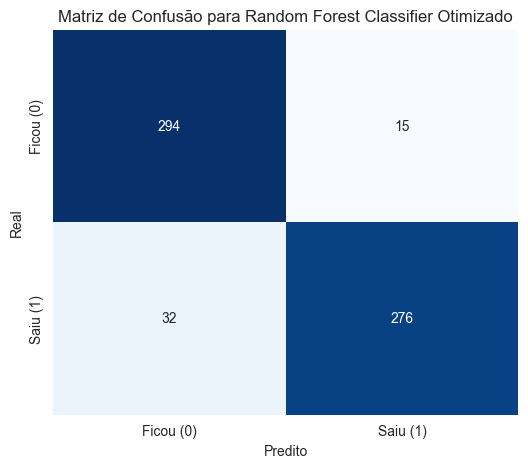

Acurácia: 0.9238
Precisão: 0.9485
Recall: 0.8961
F1-Score: 0.9215
--------------------------------------------------
Melhor modelo Random Forest salvo em: ../models\melhor_random_forest.pkl


In [4]:
print("\n--- Treinamento e Otimização do Modelo Random Forest ---")

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Iniciando treinamento e otimização para Random Forest...")
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
print(f"Melhores parâmetros para Random Forest: {grid_search_rf.best_params_}")

y_pred_rf = best_rf_model.predict(X_test)
y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
evaluate_model("Random Forest Classifier Otimizado", y_test, y_pred_rf, y_pred_proba_rf)

# Salvando o modelo
output_models_dir = '../models'
if not os.path.exists(output_models_dir):
    os.makedirs(output_models_dir)
joblib.dump(best_rf_model, os.path.join(output_models_dir, 'melhor_random_forest.pkl'))
print(f"Melhor modelo Random Forest salvo em: {os.path.join(output_models_dir, 'melhor_random_forest.pkl')}")

### Modelo 2: XGBoost Classifier


--- Treinamento e Otimização do Modelo XGBoost ---
Iniciando treinamento e otimização para XGBoost...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Melhores parâmetros para XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
--- Avaliação do Modelo: XGBoost Classifier Otimizado ---

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       309
           1       0.96      0.90      0.93       308

    accuracy                           0.93       617
   macro avg       0.93      0.93      0.93       617
weighted avg       0.93      0.93      0.93       617


Matriz de Confusão:


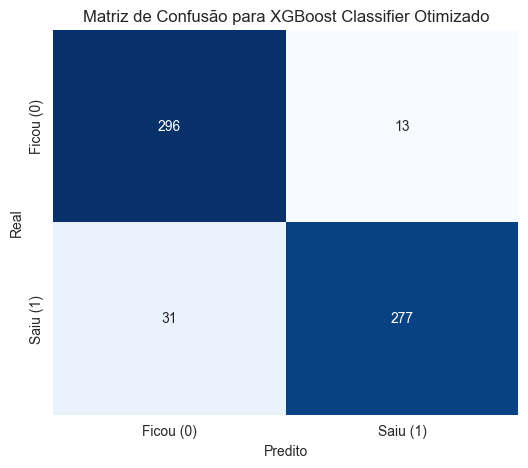

Acurácia: 0.9287
Precisão: 0.9552
Recall: 0.8994
F1-Score: 0.9264
--------------------------------------------------
Melhor modelo XGBoost salvo em: ../models\melhor_xgboost.pkl


In [5]:
print("\n--- Treinamento e Otimização do Modelo XGBoost ---")

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# obs: vou remover o 'use_label_encoder=False' para evitar o UserWarning
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Iniciando treinamento e otimização para XGBoost...")
grid_search_xgb.fit(X_train, y_train)

best_xgb_model = grid_search_xgb.best_estimator_
print(f"Melhores parâmetros para XGBoost: {grid_search_xgb.best_params_}")


y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
evaluate_model("XGBoost Classifier Otimizado", y_test, y_pred_xgb, y_pred_proba_xgb)

# salvando o modelo
output_models_dir = '../models'
if not os.path.exists(output_models_dir):
    os.makedirs(output_models_dir)
joblib.dump(best_xgb_model, os.path.join(output_models_dir, 'melhor_xgboost.pkl'))
print(f"Melhor modelo XGBoost salvo em: {os.path.join(output_models_dir, 'melhor_xgboost.pkl')}")

## Testando Previsões com os Modelos Salvos em Exemplos Aleatórios

In [6]:
''' Carregando os modelos '''

print("\n--- Carregando modelos salvos para demonstração de previsão ---")
try:
    loaded_rf_model = joblib.load('../models/melhor_random_forest.pkl')
    loaded_xgb_model = joblib.load('../models/melhor_xgboost.pkl')
    print("Modelos Random Forest e XGBoost carregados com sucesso para previsão.")
except FileNotFoundError as e:
    print(f"Erro ao carregar modelos para previsão: {e}. Certifique-se de que a célula de salvamento foi executada.")
    exit()


--- Carregando modelos salvos para demonstração de previsão ---
Modelos Random Forest e XGBoost carregados com sucesso para previsão.


In [7]:
''' Função de demonstração '''

def testar_previsao_modelo_em_exemplos(modelo, nome_modelo, X_data, y_true, num_exemplos=5):
    print(f"\n--- Demonstração de Previsão com {nome_modelo} ---")

    if len(X_data) < num_exemplos:
        print(f"Número de exemplos para testar ({num_exemplos}) é maior que o tamanho do dataset ({len(X_data)}). Testando todos os exemplos disponíveis.")
        random_indices = X_data.index.values
    else:
        random_indices = np.random.choice(X_data.index.values, num_exemplos, replace=False)

    for i, idx in enumerate(random_indices):
        sample_X = X_data.loc[[idx]]
        true_y = y_true.loc[idx]

        pred_class = modelo.predict(sample_X)[0] # [0] ==> escalar valor
        pred_proba = modelo.predict_proba(sample_X)[0, 1] # (churn)

        print(f"\nExemplo {i+1} (Índice Original no X_test: {idx}):")
        print(f"  Modelo: {nome_modelo}")
        print(f"  Previsão (0=Fica, 1=Sai): {pred_class}")
        print(f"  Probabilidade de Sair: {pred_proba:.4f}")
        print(f"  Valor Real (0=Ficou, 1=Saiu): {true_y}")

        if pred_class == true_y:
            print("  Resultado: PREVISÃO CORRETA!")
        else:
            print("  Resultado: PREVISÃO INCORRETA.")


In [8]:
''' Teste dos modelos com exemplos aleatórios '''

# Testando o Random Forest
testar_previsao_modelo_em_exemplos(loaded_rf_model, "Random Forest Carregado", X_test, y_test, num_exemplos=5)

# Testando o XGBoost
testar_previsao_modelo_em_exemplos(loaded_xgb_model, "XGBoost Carregado", X_test, y_test, num_exemplos=5)


--- Demonstração de Previsão com Random Forest Carregado ---

Exemplo 1 (Índice Original no X_test: 431):
  Modelo: Random Forest Carregado
  Previsão (0=Fica, 1=Sai): 0
  Probabilidade de Sair: 0.2600
  Valor Real (0=Ficou, 1=Saiu): 0
  Resultado: PREVISÃO CORRETA!

Exemplo 2 (Índice Original no X_test: 473):
  Modelo: Random Forest Carregado
  Previsão (0=Fica, 1=Sai): 0
  Probabilidade de Sair: 0.2400
  Valor Real (0=Ficou, 1=Saiu): 0
  Resultado: PREVISÃO CORRETA!

Exemplo 3 (Índice Original no X_test: 30):
  Modelo: Random Forest Carregado
  Previsão (0=Fica, 1=Sai): 0
  Probabilidade de Sair: 0.3650
  Valor Real (0=Ficou, 1=Saiu): 0
  Resultado: PREVISÃO CORRETA!

Exemplo 4 (Índice Original no X_test: 420):
  Modelo: Random Forest Carregado
  Previsão (0=Fica, 1=Sai): 0
  Probabilidade de Sair: 0.4450
  Valor Real (0=Ficou, 1=Saiu): 0
  Resultado: PREVISÃO CORRETA!

Exemplo 5 (Índice Original no X_test: 606):
  Modelo: Random Forest Carregado
  Previsão (0=Fica, 1=Sai): 1
  Prob